In [1]:
%load_ext autoreload
%autoreload 2

## Oxygen in temperature space
Examine the covariability of temperature and oxygen in the subsurface Southern Ocean

NOTES
- [x] Select below the climatological winter mixed layer depth
- [x] Take anomalies (at each point in space and time) relative to climatological mean
- [ ] Take a look at the variability itself - variance of T and o2 over period

Note that CM4 and ESM4 have different saved variables: only time-series data for CM4 o2, and no o2sat for CM4

In [2]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import matplotlib.pyplot as plt
import os
from dask.diagnostics import ProgressBar

In [3]:
config_id = 'ESM4_piControl_D'

ds = xr.Dataset()
if config_id == 'ESM4_piControl_D':
    pathDict = {'pp':('/archive/oar.gfdl.cmip6/ESM4/DECK/'+config_id+'/'+
                        'gfdl.ncrc4-intel16-prod-openmp/pp'),
                'out':'ts',
                'local':'annual/5yr',
                'time':'03*'}
    pathDict['ppname']='ocean_cobalt_omip_tracers_year_z_1x1deg'
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    # gu.core.issue_dmget(gridpath)
    variables = ['o2','o2sat']
    for variable in variables:
        pathDict['add'] = variable
        path=gu.core.get_pathspp(**pathDict)
        # gu.core.issue_dmget(path)
        ds[variable] = gu.core.open_frompp(**pathDict)[variable]
    
    pathDict['ppname']='ocean_annual_z_1x1deg'
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    gu.core.issue_dmget(gridpath)
    variables = ['thetao','volcello']
    for variable in variables:
        pathDict['add'] = variable
        path=gu.core.get_pathspp(**pathDict)
        gu.core.issue_dmget(path)
        ds[variable] = gu.core.open_frompp(**pathDict)[variable]
    grid = xr.open_dataset(gridpath)
ds = ds.squeeze()

In [4]:
# Load the maximum mixed layer depth
pathDict['ppname']='ocean_annual_1x1deg'
pathDict['add']='MLD_003_max'
path = gu.core.get_pathspp(**pathDict)
# gu.core.issue_dmget(path)
ds[pathDict['add']] = gu.core.open_frompp(**pathDict)[pathDict['add']]

In [5]:
# Select subsurface
variables = ['o2','o2sat','thetao']
for variable in variables:
    ds[variable] = ds[variable].where(ds['z_l']>ds['MLD_003_max'].max('time'))

In [6]:
# Select Southern Ocean
SOlat = -30
ds = ds.where(grid['geolat']<=SOlat,drop=True)
grid = grid.where(grid['geolat']<=SOlat,drop=True)
# Select subsurface
# dsSO = dsSO.sel({'z_l':slice(200,7000)})

In [7]:
figsavedir = '../figures/'+config_id+'/SouthernOcean/'
if ~os.path.isdir(figsavedir):
    cmd=('mkdir -p %s' %figsavedir)
    os.system(cmd)

In [8]:
# Calculate o2 and temp anomalies
ds_anom = ds-ds.mean('time')
# Replace volume with normal volume
ds_anom['volcello']=ds['volcello']

#### First look at variability

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


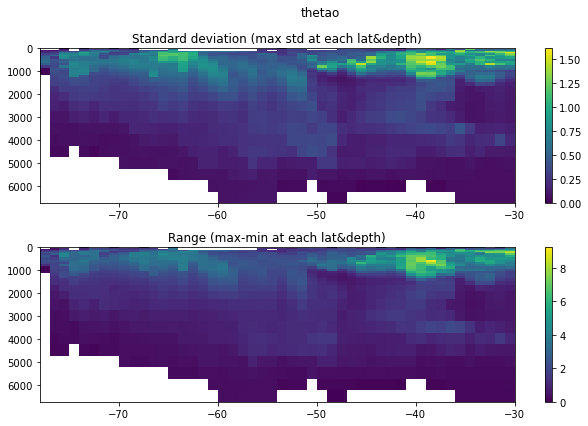

In [9]:
variable = 'thetao'
lon=210

x = ds_anom['lat']
y = ds_anom['z_l']
fig,ax = plt.subplots(figsize=(9,6),nrows=2)

axnow = ax[0]
z = ds_anom[variable].std('time').max('lon')
im = axnow.pcolormesh(x,y,z,shading='auto',vmin=0)
axnow.invert_yaxis()
cb = plt.colorbar(im,ax=axnow)
axnow.set_title('Standard deviation (max std at each lat&depth)')

axnow = ax[1]
z = ds_anom[variable].max(['time','lon'])-ds_anom[variable].min(['time','lon'])
im = axnow.pcolormesh(x,y,z,shading='auto',vmin=0)
axnow.invert_yaxis()
cb = plt.colorbar(im,ax=axnow)
axnow.set_title('Range (max-min at each lat&depth)')

plt.suptitle(variable)
fig.tight_layout()

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


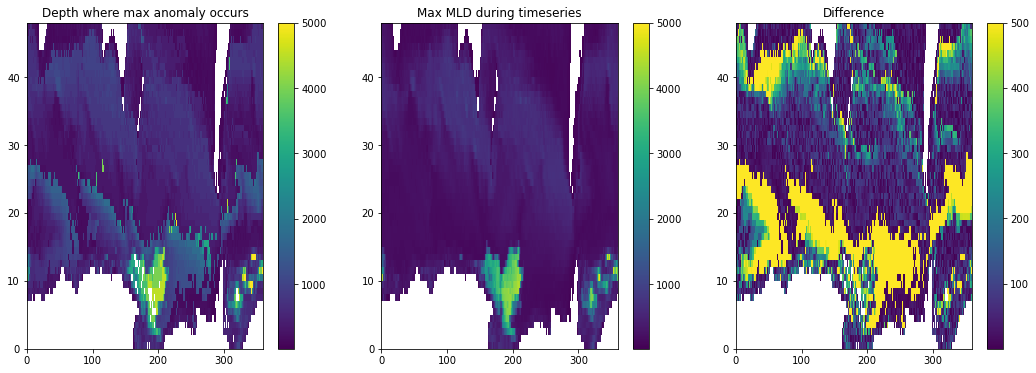

In [10]:
## Check that it's below the max mixed layer
depth_of_max = ds_anom[variable].max('time').idxmax('z_l')
maxMLD = ds['MLD_003_max'].max('time')
fig,ax = plt.subplots(figsize=(18,6),ncols=3)
im = ax[0].pcolormesh(depth_of_max,vmax=5000)
ax[0].set_title('Depth where max anomaly occurs')
plt.colorbar(im,ax=ax[0])
im = ax[1].pcolormesh(maxMLD,vmax=5000)
ax[1].set_title('Max MLD during timeseries')
plt.colorbar(im,ax=ax[1])
im = ax[2].pcolormesh((depth_of_max-maxMLD),vmax=500)
ax[2].set_title('Difference')
plt.colorbar(im,ax=ax[2])

#### Distribution of temperature anomalies

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


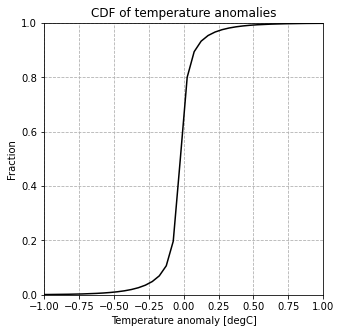

In [11]:
thetao_bins = np.arange(-6,6,0.05)
hs_t = xr.Dataset()
hs_t['volcello'] = histogram(ds_anom['thetao'],
                             bins=[thetao_bins],
                             weights=ds_anom['volcello'],
                             dim=['lat','lon','z_l','time'])
hs_t = hs_t.squeeze()
hs_t = hs_t/hs_t.sum('thetao_bin')
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(hs_t['thetao_bin'],hs_t['volcello'].cumsum('thetao_bin'),'k-')
ax.set_xlim([-1,1])
ax.set_ylim([0,1])
ax.set_title('CDF of temperature anomalies')
ax.set_ylabel('Fraction')
ax.set_xlabel('Temperature anomaly [degC]')
ax.grid(linestyle='--')

#### Oxygen in temperature space

In [12]:
def calc_weightedstats_hs(hs,dim):
    array = hs[dim]*xr.ones_like(hs['volcello'])
    stats = xr.Dataset()
    stats['mean'] = array.weighted(hs['volcello'].fillna(0)).mean(dim)
    stats['std'] = array.weighted(hs['volcello'].fillna(0)).std(dim)
    return stats
    
def plot_hs_o2(ax,hs):
    hs = hs.squeeze()
    # stats
    stats = calc_weightedstats_hs(hs,'o2_bin')
    
    # plot
    im=ax.pcolormesh(hs['thetao_bin'],
                  hs['o2_bin'],
                  hs['volcello'].transpose(),
                  cmap='magma_r',
                  vmax=0.25)
    cb = plt.colorbar(im,ax=ax)
    ax.errorbar(stats['thetao_bin'],stats['mean'],yerr=stats['std'],
                linestyle='',
                marker='o',
                markerfacecolor='w',
                markeredgecolor='gray',
                ecolor='gray',
                alpha=0.5,
                label='Weighted-mean O2 in each temperature bin')
    ax.legend()
    ax.set_ylabel('OXYGEN [mol m-3]')
    ax.set_xlabel('TEMPERATURE [degC]')
    ax.grid(visible=True,which='major')
    cb.ax.set_ylabel('FRACTION \n(in each temperature bin)');
    
def plot_hs_o2_o2sat(ax,hs_o2,hs_o2sat):
    # First plot o2
    plot_hs_o2(ax,hs_o2)
    # Add oxygen saturation
    stats_o2s = calc_weightedstats_hs(hs_to2s,'o2sat_bin')
    ax.plot(stats_o2s['thetao_bin'],stats_o2s['mean'],
            linestyle=':',
            color='tab:green',
            marker='.',
            markerfacecolor='w',
            markeredgecolor='tab:green',
            label='Weighted-mean O2sat')
    ax.legend()

In [13]:
thetao_bins = np.arange(-0.25,0.25,0.01)
o2_bins = np.arange(-0.01,0.01,0.0005)
hs_to2 = xr.Dataset()
hs_to2['volcello'] = histogram(ds_anom['thetao'],ds_anom['o2'],
                             bins=[thetao_bins,o2_bins],
                             weights=ds_anom['volcello'],
                             dim=['lat','lon','z_l','time'])
hs_to2 = hs_to2.squeeze()
# normalize in each temperature bin
hs_to2 = hs_to2/hs_to2.sum('o2_bin')

In [14]:
hs_to2s = xr.Dataset()
hs_to2s['volcello'] = histogram(ds_anom['thetao'],ds_anom['o2sat'],
                             bins=[thetao_bins,o2_bins],
                             weights=ds_anom['volcello'],
                             dim=['lat','lon','z_l','time'])
hs_to2s = hs_to2s.squeeze()
# normalize in each temperature bin
hs_to2s = hs_to2s/hs_to2s.sum('o2sat_bin')

#### TOTAL

[#####                                   ] | 12% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  5.7s
[####                                    ] | 12% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  7.8s


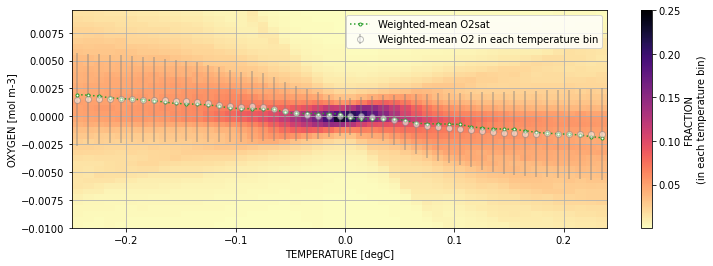

In [15]:
fig,ax = plt.subplots(figsize=(12,4))
with ProgressBar():
    plot_hs_o2_o2sat(ax,hs_to2,hs_to2s)
fig.savefig(figsavedir+'o2_in_thetao.anom.histogram.'+pathDict['time']+'.png',transparent=True,dpi=300)

##### Look at difference between mean o2 and o2sat as a function of temperature anomaly

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


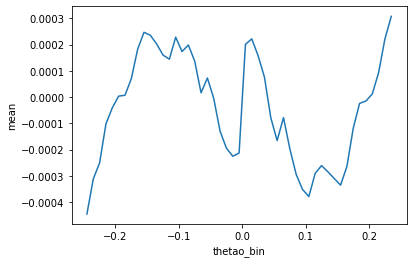

In [19]:
stats_hs_to2 = calc_weightedstats_hs(hs_to2,dim='o2_bin')
stats_hs_to2s = calc_weightedstats_hs(hs_to2s,dim='o2sat_bin')
do2 = stats_hs_to2['mean']-stats_hs_to2s['mean']
do2.plot()

In [18]:
stats_hs_to2

<xarray.Dataset>
Dimensions:     (thetao_bin: 49)
Coordinates:
  * thetao_bin  (thetao_bin) float64 -0.245 -0.235 -0.225 ... 0.215 0.225 0.235
Data variables:
    mean        (thetao_bin) float64 dask.array<chunksize=(49,), meta=np.ndarray>
    std         (thetao_bin) float64 dask.array<chunksize=(49,), meta=np.ndarray>

#### Basin break-down

In [278]:
lon_bins = np.array([-300,-230,-150,-70,20,50])
ds_anom['geolon']=(grid*xr.ones_like(ds_anom['o2']))['geolon']
hs_to2b = xr.Dataset()
hs_to2b['volcello'] = histogram(ds_anom['thetao'],ds_anom['o2'],ds_anom['geolon'],
                             bins=[thetao_bins,o2_bins,lon_bins],
                             weights=ds_anom['volcello'],
                             dim=['lat','lon','z_l','time'])
hs_to2b = hs_to2b.squeeze()
basins=['IndianEast','PacificWest','PacificEast','Atlantic','IndianWest']
hs_to2b = hs_to2b.rename({'geolon_bin':'basin'}).assign_coords({'basin':basins})
# normalize in each temperature bin
hs_to2b = hs_to2b/hs_to2b.sum('o2_bin')

In [279]:
# Oxygen saturation
hs_to2sb = xr.Dataset()
hs_to2sb['volcello'] = histogram(ds_anom['thetao'],ds_anom['o2sat'],ds_anom['geolon'],
                             bins=[thetao_bins,o2_bins,lon_bins],
                             weights=ds_anom['volcello'],
                             dim=['lat','lon','z_l','time'])
hs_to2sb = hs_to2sb.squeeze()
basins=['IndianEast','PacificWest','PacificEast','Atlantic','IndianWest']
hs_to2sb = hs_to2sb.rename({'geolon_bin':'basin'}).assign_coords({'basin':basins})
# normalize in each temperature bin
hs_to2sb = hs_to2sb/hs_to2sb.sum('o2sat_bin')

[#####                                   ] | 13% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  6.2s
[#####                                   ] | 12% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  5.9s
[#####                                   ] | 13% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.8s
[#####                                   ] | 12% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  5.7s
[#####                                   ] | 13% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.8s
[#####                                   ] | 12% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  5.9s
[#####                                   ] | 13% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.1s
[#####                                   ] | 12% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  5.8s
[#####                                   ] | 13% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  6.2s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  6.1s
[#####                                   ] | 12% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed |  5.8s


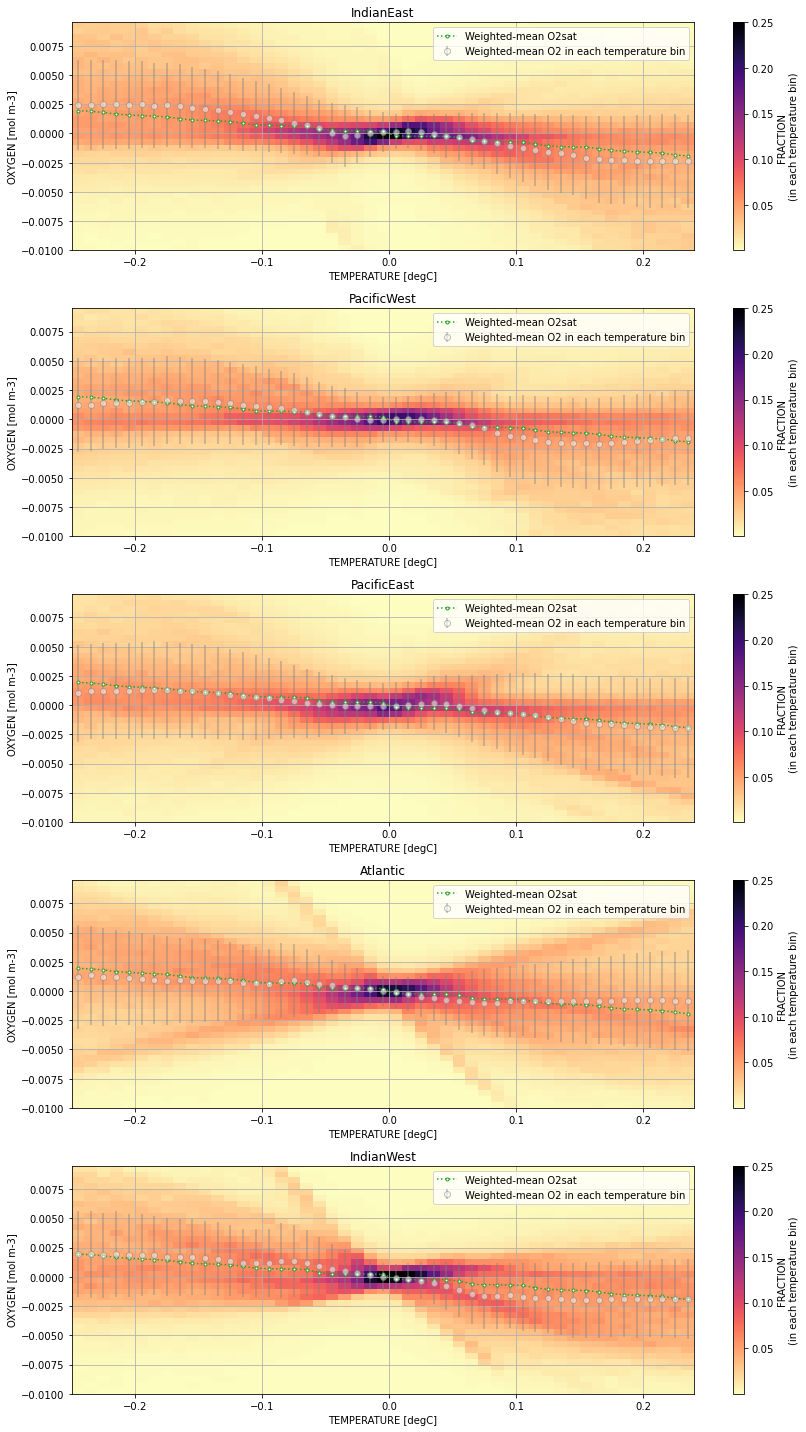

In [280]:
nb = len(hs_to2b['basin'])
fig,axarr = plt.subplots(figsize=(12,4*nb),nrows=nb)
for i,basin in enumerate(hs_to2b['basin']):
    ax = axarr.flat[i]
    with ProgressBar():
        plot_hs_o2_o2sat(ax,hs_to2b.sel({'basin':basin}),hs_to2sb.sel({'basin':basin}))
    ax.set_title(basin.values)
fig.tight_layout()
fig.savefig(figsavedir+'o2_in_thetao.anom.histogram_bybasin.'+pathDict['time']+'.png',transparent=True,dpi=300)

### Visualize spatial distribution of oxygen in temperature space

In [281]:
from xgcm import Grid

In [282]:
# Build an xgcm grid object in vertical dimension
z_i = np.array([0])
for k in range(len(ds['z_l'])):
    dz = ds['z_l'][k]-z_i[-1]
    z_i = np.append(z_i,ds['z_l'][k]+dz)
ds['z_i'] = z_i
ds['dz'] = ds['z_l'].copy(data=ds['z_i'].diff('z_i'))

coords = {'Z':{'center':'z_l','outer':'z_i'}}
metrics = {'Z':['dz']}
xgrid = Grid(ds, coords=coords, metrics=metrics, periodic=False)

In [284]:
# Conservatively remap thetao and thicknesses
ds_anom['thetao_i']=xgrid.interp(ds_anom['thetao'],'Z',boundary='extend')
ds_anom = ds_anom.chunk({'z_i':-1})
ds_thetao = xr.Dataset()
ds_thetao['o2_dz'] = xgrid.transform(ds_anom['o2']*ds['dz'],
                                        'Z',
                                        target=thetao_bins,
                                        target_data=ds_anom['thetao_i'],
                                        method='conservative')
ds_thetao['o2sat_dz'] = xgrid.transform(ds_anom['o2sat']*ds['dz'],
                                        'Z',
                                        target=thetao_bins,
                                        target_data=ds_anom['thetao_i'],
                                        method='conservative')
ds_thetao['dz'] = xgrid.transform(ds['dz']*xr.ones_like(ds_anom['o2']),
                                    'Z',
                                    target=thetao_bins,
                                    target_data=ds_anom['thetao_i'],
                                    method='conservative')
ds_thetao = ds_thetao.squeeze()

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


#### ZONAL MEANS

In [298]:
# Latitude-depth plot
def plot_xmean_theta(ax,ds_thetao):
    tmp = ds_thetao['o2_dz'].sum('lon')/ds_thetao['dz'].sum('lon')
    im = ax.pcolormesh(tmp['lat'],
                       tmp['thetao_i'],
                       tmp.mean('time').transpose(),
                       shading='auto',
                       vmin=-0.005,vmax=0.005,
                       cmap='RdBu_r')
    cb = plt.colorbar(im,ax=ax)
    ax.set_xlabel('LATITUDE [degN]')
    ax.set_ylabel('TEMPERATURE [degC]')
    cb.ax.set_ylabel('OXYGEN [mol m-3]')
    ax.set_title('ZONAL MEAN OXGYEN IN TEMPERATURE-SPACE');

[##                                      ] | 6% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[###############################         ] | 78% Completed |  3.8s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  4.9s


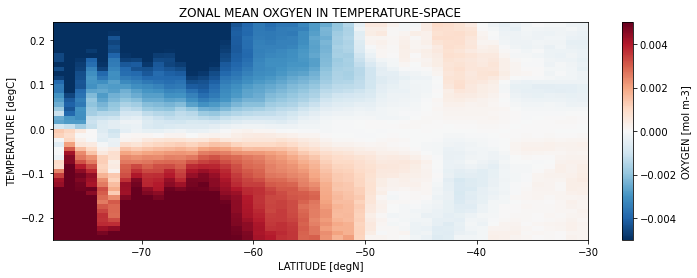

In [299]:
fig,ax = plt.subplots(figsize=(12,4))
with ProgressBar():
    plot_xmean_theta(ax,ds_thetao)
fig.savefig(figsavedir+'o2_in_thetao.anom.xmean.'+pathDict['time']+'.png',transparent=True,dpi=300)

[##                                      ] | 5% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[############################            ] | 71% Completed |  3.9s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  5.0s
[##                                      ] | 5% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[#############################           ] | 74% Completed |  4.3s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  5.2s
[##                                      ] | 5% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[#############################           ] | 73% Completed |  3.9s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  4.8s
[##                                      ] | 5% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[############################            ] | 71% Completed |  4.0s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  5.0s
[##                                      ] | 5% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[##############################          ] | 76% Completed |  3.9s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  4.8s


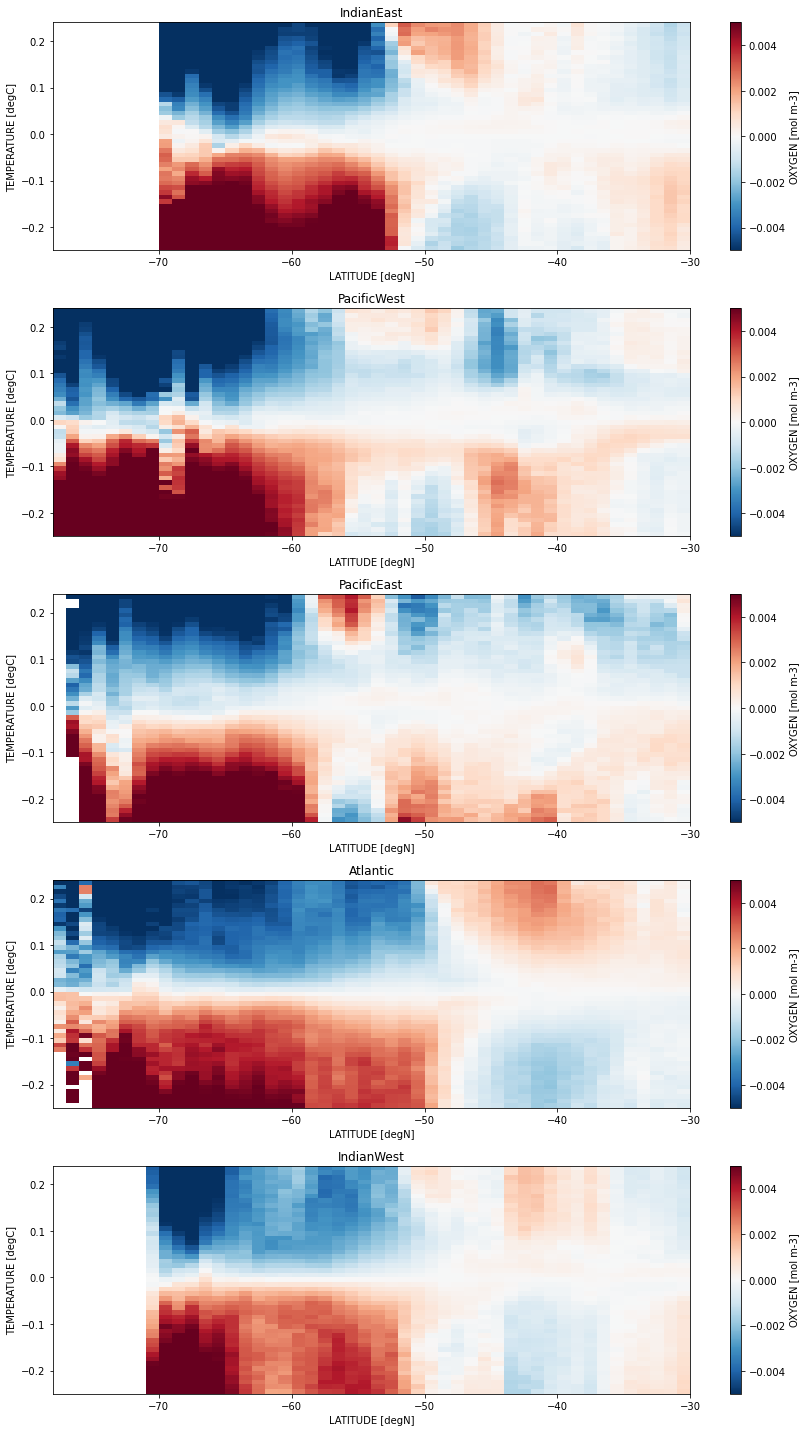

In [300]:
# Basins
nb = len(lon_bins)-1
fig,axarr = plt.subplots(figsize=(12,4*nb),nrows=nb)
for i in range(nb):
    ax = axarr.flat[i]
    cond = (grid['geolon']>=lon_bins[i]) & (grid['geolon']<lon_bins[i+1])
    ds_thetao_b = ds_thetao.where(cond,drop=True)
    with ProgressBar():
        plot_xmean_theta(ax,ds_thetao_b)
    ax.set_title(basins[i])
fig.tight_layout()
fig.savefig(figsavedir+'o2_in_thetao.anom.xmean_bybasin.'+pathDict['time']+'.png',transparent=True,dpi=300)

#### MAPS

In [301]:
# Maps at certain temperature values
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# import warnings
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [311]:
def plot_map_on_theta(ax,ds_thetao,grid):
    
    ds_thetao['o2']=ds_thetao['o2_dz']/ds_thetao['dz']
    ds_thetao['o2sat']=ds_thetao['o2sat_dz']/ds_thetao['dz']
    ds_thetao['o2']=ds_thetao['o2'].where(ds_thetao['o2']>0,np.nan)
    ds_thetao['do2']=ds_thetao['o2']-ds_thetao['o2sat']

    im = ax.pcolormesh(grid['geolon'],
                       grid['geolat'],
                       ds_thetao['do2'].sel(thetao_i=thetao_i,method='nearest').mean('time'),
                       transform=ccrs.PlateCarree(),
                       cmap='winter',
                       vmin=-0.01,vmax=0.01)
    ax.coastlines(resolution='110m',zorder=11)
    ax.add_feature(cfeature.LAND,zorder=10)
    ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    ax.set_yticks([-60, -45], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                           degree_symbol='',
                                           dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                      degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    cb = plt.colorbar(im,ax=ax,fraction=0.01,pad=0.05)
    cb.ax.set_ylabel('O2 - O2sat [mol m-3]')

[#                                       ] | 4% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[#####################################   ] | 93% Completed |  5.4s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  6.5s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of p

[##                                      ] | 5% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[#####################################   ] | 92% Completed |  5.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  6.2s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of p

[##                                      ] | 5% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[#####################################   ] | 92% Completed |  4.9s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  5.9s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-p

[#                                       ] | 4% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[#####################################   ] | 92% Completed |  5.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  6.1s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-p

[#                                       ] | 4% Completed |  0.2s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[####################################    ] | 92% Completed |  5.3s

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  6.3s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of p

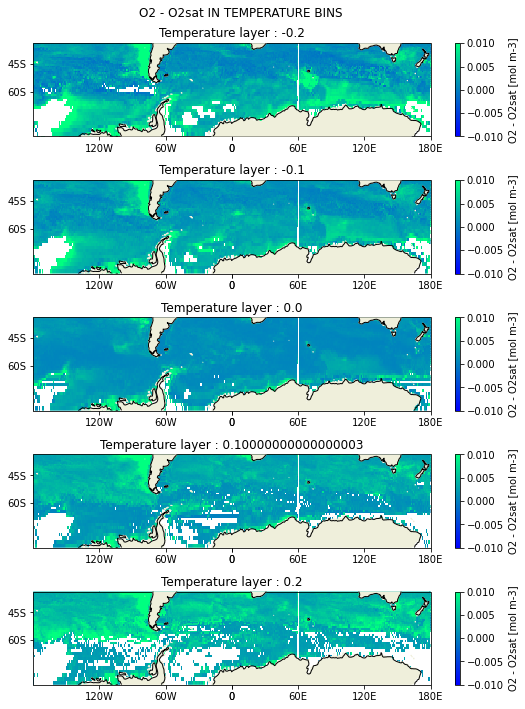

In [312]:
thetao_is = np.arange(-0.2,0.21,0.1)
nt = len(thetao_is)
fig,axarr = plt.subplots(figsize=(8,2*nt),
                         nrows=nt,
                         subplot_kw={'projection':ccrs.Mercator(min_latitude=-75.0)})
for i,thetao_i in enumerate(thetao_is):
    ax = axarr.flat[i]
    with ProgressBar():
        plot_map_on_theta(ax,ds_thetao,grid)
    ax.set_title('Temperature layer : %s' %thetao_i)
plt.suptitle('O2 - O2sat IN TEMPERATURE BINS')
fig.tight_layout()
fig.savefig(figsavedir+'o2_in_thetao.anom.map_bylayer.'+pathDict['time']+'.png',transparent=True,dpi=300)

# ARCHIVE

In [94]:
thetao_bins = np.arange(-2,30,0.5)
hs = xr.Dataset()
hs['o2volcello'] = histogram(dsSO['thetao'],
                             bins=thetao_bins,
                             weights=dsSO['o2']*dsSO['volcello'],
                             dim=['lat','lon','z_l'])
hs['volcello'] = histogram(dsSO['thetao'],
                             bins=thetao_bins,
                             weights=dsSO['volcello'],
                             dim=['lat','lon','z_l'])
hs['o2'] = hs['o2volcello']/hs['volcello']
hs = hs.squeeze()

In [76]:
ds['o2']

<xarray.DataArray 'o2' (time: 1, z_l: 35, lat: 180, lon: 360)>
dask.array<open_dataset-185ccec6c31594300b6aab13bee8011co2, shape=(1, 35, 180, 360), dtype=float32, chunksize=(1, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0398-07-02 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Dissolved Oxygen Concentration
    units:          mol m-3
    cell_measures:  volume: volcello area: areacello
    standard_name:  mole_concentration_of_dissolved_molecular_oxygen_in_sea_w...
    interp_method:  conserve_order1
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT